**DATASET LINK1 :** https://www.kaggle.com/paultimothymooney/kermany2018 <BR>
**DATASET LINK2 :** https://data.mendeley.com/datasets/rscbjbr9sj/2

**Necessary modules**

In [1]:
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.layers.core import Dense,Dropout
from keras.layers import Conv2D,ReLU,MaxPooling2D,BatchNormalization,Input,Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import seaborn as sn
import pandas as pd


**Paths**

In [2]:
path = '../input/kermany2018/OCT2017 '

train_normal_folder = os.path.join(path,'train','NORMAL')
train_drusen_folder = os.path.join(path,'train','DRUSEN')
train_cnv_folder = os.path.join(path,'train','CNV')

test_normal_folder = os.path.join(path,'test','NORMAL')
test_drusen_folder = os.path.join(path,'test','DRUSEN')
test_cnv_folder = os.path.join(path,'test','CNV')

val_normal_folder = os.path.join(path,'val','NORMAL')
val_drusen_folder = os.path.join(path,'val','DRUSEN')
val_cnv_folder = os.path.join(path,'val','CNV')

train_normal_filenames = os.listdir(train_normal_folder)
train_drusen_filenames = os.listdir(train_drusen_folder)
train_cnv_filenames = os.listdir(train_cnv_folder)

test_normal_filenames = os.listdir(test_normal_folder)
test_drusen_filenames = os.listdir(test_drusen_folder)
test_cnv_filenames = os.listdir(test_cnv_folder)

val_normal_filenames = os.listdir(val_normal_folder)
val_drusen_filenames = os.listdir(val_drusen_folder)
val_cnv_filenames = os.listdir(val_cnv_folder)

**Merging folder path and filename**

In [3]:
def merge_folder_and_filenames(_folder,_filenames,label):
    merged_paths = []
    for filename in _filenames: 
        path = os.path.join(_folder,filename)
        path_label = (path,label) 
        merged_paths.append(path_label)
    return (merged_paths)

In [4]:
# 0 Normal
# 1 Drusen
# 2 CNV
train_paths=[]
train_paths += merge_folder_and_filenames(train_normal_folder,train_normal_filenames,0)
train_paths += merge_folder_and_filenames(train_drusen_folder,train_drusen_filenames,1)
train_paths += merge_folder_and_filenames(train_cnv_folder,train_cnv_filenames,2)

train_paths += merge_folder_and_filenames(val_normal_folder,val_normal_filenames,0)#merged train and val
train_paths +=  merge_folder_and_filenames(val_drusen_folder,val_drusen_filenames,1)#merged train and val
train_paths += merge_folder_and_filenames(val_cnv_folder,val_cnv_filenames,2)#merged train and val
random.Random(123).shuffle(train_paths)
test_paths=[]
test_paths += merge_folder_and_filenames(test_normal_folder,test_normal_filenames,0)
test_paths +=  merge_folder_and_filenames(test_drusen_folder,test_drusen_filenames,1)
test_paths += merge_folder_and_filenames(test_cnv_folder,test_cnv_filenames,2)
random.Random(123).shuffle(train_paths)



**Number of image in sets**

In [5]:
def show_number_of_image(set_name,image_names,image_numbers):
    plt.bar(image_names, image_numbers)
    plt.title(set_name)
    plt.ylabel('# of Number')
    plt.show()
    for i in  range(len(image_names)):
        print(f'{image_names[i]}: {image_numbers[i]}')

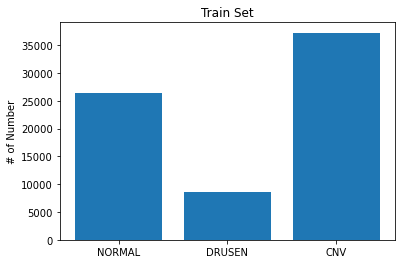

NORMAL: 26323
DRUSEN: 8624
CNV: 37213


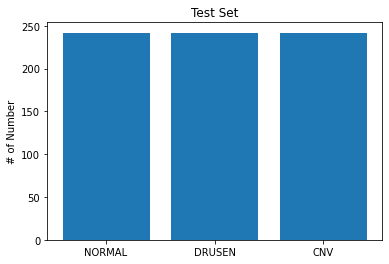

NORMAL: 242
DRUSEN: 242
CNV: 242


In [6]:
image_names= ['NORMAL','DRUSEN','CNV']

show_number_of_image('Train Set',image_names,
                     [len(train_normal_filenames+val_normal_filenames),
                      len(train_drusen_filenames+val_drusen_filenames),
                      len(train_cnv_filenames+val_cnv_filenames)])

show_number_of_image('Test Set',image_names,
                     [len(test_normal_filenames),
                      len(test_drusen_filenames),
                      len(test_cnv_filenames)])

**Function for filtering on image**

In [7]:
def image_filter(img):
    img = cv2.medianBlur(img,5)
    kernel = np.ones((3,3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=5)
    mean = np.sum(img) / img.size # mean of image rgb
    img[img < mean] = 0
    img = cv2.resize(src = img, dsize= (128,128))
    return img

**Image before and after filtering**

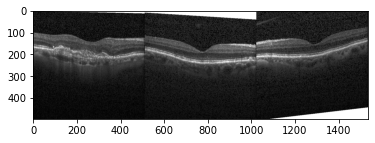

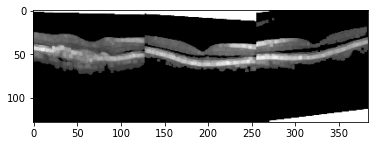

In [8]:
def show_before_and_after_image():
    img_cnv = cv2.imread('../input/kermany2018/OCT2017 /train/CNV/CNV-1016042-1.jpeg',cv2.IMREAD_GRAYSCALE)
    img_drusen = cv2.imread('../input/kermany2018/OCT2017 /train/DRUSEN/DRUSEN-1001666-1.jpeg',cv2.IMREAD_GRAYSCALE)
    img_normal = cv2.imread('../input/kermany2018/OCT2017 /train/NORMAL/NORMAL-1001666-1.jpeg',cv2.IMREAD_GRAYSCALE)
    img_cnv_clean = image_filter(img_cnv)
    img_drusen_clean = image_filter(img_drusen)
    img_normal_clean = image_filter(img_normal)
    g1 = np.hstack((img_cnv,img_drusen,img_normal))
    g2 = np.hstack((img_cnv_clean,img_drusen_clean,img_normal_clean))
    plt.figure()
    plt.imshow(g1,cmap='gray')
    plt.figure()
    plt.imshow(g2,cmap='gray')
    return
show_before_and_after_image()

**Preparing Dataset**

In [9]:
def read_image_from_file(path):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = image_filter(img)
    img = img.reshape((1,128,128,1)) / 255
    return img

In [10]:
def train_generator():
    for data in train_paths:
        path = data[0]
        y_data = tf.keras.utils.to_categorical(data[1],num_classes = 3).reshape(1,3)
        x_data = read_image_from_file(path)
        yield (x_data,y_data)

def test_generator():
    for data in test_paths:
        path = data[0]
        y_data = tf.keras.utils.to_categorical(data[1],num_classes = 3).reshape(1,3)
        x_data = read_image_from_file(path)
        yield (x_data,y_data)

**CNN Model**

In [11]:
def create_model():
    model= Sequential()
    model.add(Input(shape = (128,128,1)))
    # CONV
    model.add(Conv2D(filters = 128 ,kernel_size = (3,3),strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3,3)))
    model.add(Conv2D(filters = 32,kernel_size = (3,3),strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters = 32,kernel_size = (3,3),strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(Conv2D(filters = 32,kernel_size = (3,3),strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    # TBK
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units = 288, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(optimizer = Adam(learning_rate = 0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    model.summary()
    return model

def model_fit(model,tf_dataset):
    history = model.fit(tf_dataset,
                        epochs=10,
                        shuffle=False,
                        batch_size=500,
                        workers=400,
                        use_multiprocessing=True)
    model.save('model.h5')
    test_loss, test_acc = model.evaluate(test_ds)
    print('Evaluate Accuracy:',test_acc)
    return history

In [12]:
def history_information(history):
    acc= history.history['accuracy']
    loss = history.history['loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc,'o',label = 'Train acc')
    plt.plot(epochs, loss,'b',label='Loss')
    plt.title('Train accuracy')
    plt.legend()
    plt.show()

In [13]:
def predict_model(model,x_test):
    y_predict = model.predict(x_test)
    y_predict = np.where(y_predict > 0.5, 1, 0).astype(np.int32) # if prediction > 0.5 then 1 else 0
    y_predict = y_predict.astype(np.int32)
    return y_predict

In [14]:
def confusion_matrix(y_true,y_predict,num_class):
    predict = np.where(y_predict.astype(np.int32)==1)[1]
    true = np.where(y_test.astype(np.int32)==1)[1]
    cm = np.zeros((3,3),dtype=np.int32)
    for i in range(predict.size):
        cm[true[i]][predict[i]] += 1
    return cm

In [15]:
def cm_report(cm):
    report = dict()
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)    
    report['Accuracy']= ACC = (TP+TN)/(TP+FP+FN+TN)
    report['Precision'] =  PPV = TP/(TP+FP)
    report['Predictive'] =  NPV = TN/(TN+FN)
    report['Recall'] = TPR = TP/(TP+FN)
    report['Specificity'] = TNR = TN/(TN+FP)
    report['F1'] =  NPV = (2*TP)/((2*TP)+FP+FN)
    
    #for title,values in report.items():
    #   print(f'{values}\t{title}')
    return report

In [16]:
def separate_dataset(tf_dataset): # parametreden tf.Dataset tipinde bir input alınıyor 
    x_data = []
    y_data = []
    for x_tensor, y_tensor in tf_dataset: # x ve y tensorlerini ayrıyoruz
        for x in x_tensor:
            x_data.append(x.numpy()) # tensor tipindeki verileri nparray cevirip listeye alıyoruz
        for y in y_tensor:
            y_data.append(y.numpy()) 
    x_data = np.array(x_data)  #listeyi nparray  ceviriyoruz
    y_data = np.array(y_data) 
    return x_data,y_data

**Model Training**

In [17]:
train_ds = tf.data.Dataset.from_generator(train_generator,
                                         (tf.float32,tf.float32),
                                         (tf.TensorShape([1,128,128,1]),tf.TensorShape([1,3])))
test_ds = tf.data.Dataset.from_generator(test_generator,
                                         (tf.float32,tf.float32),
                                         (tf.TensorShape([1,128,128,1]),tf.TensorShape([1,3])))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9

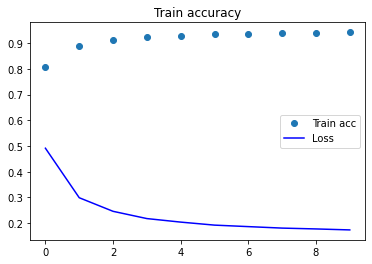

In [18]:
cnn_model = create_model()
history = model_fit(cnn_model,train_ds)
history_information(history)

# Model Testing

In [19]:
x_test,y_test = separate_dataset(test_ds)

In [20]:
y_predict = predict_model(cnn_model,x_test)
cm= confusion_matrix(y_test,y_predict,3)
report = cm_report(cm)

**Confusion Matrix and Report**

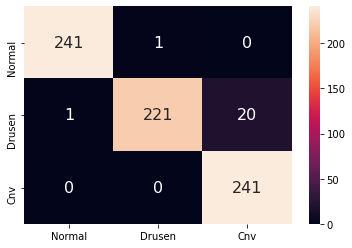

,Accuracy,Precision,Predictive,Recall,Specificity,F1
Normal,0.997241,0.995868,0.997930,0.995868,0.997930,0.995868
Drusen,0.969655,0.995495,0.958250,0.913223,0.997930,0.952586
CNV,0.972414,0.923372,1.000000,1.000000,0.958678,0.960159


In [21]:
target_names=['Normal','Drusen','Cnv']
cm_df = pd.DataFrame(cm,index=target_names,columns=target_names)
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.show()

target_names=['Accuracy','Precision','Predictive','Recall','Specificity','F1']
clas=['Normal','Drusen','CNV']
report_df = pd.DataFrame(report,index=clas,columns=target_names)
report_df.style